# Autodiff

> Dieses Vorlesungsbeispiel basiert auf folgender Quelle: [https://github.com/ioskn/mldl_htwg/blob/master/autodiff/jax_autodiff.ipynb](https://github.com/ioskn/mldl_htwg/blob/master/autodiff/jax_autodiff.ipynb)

JAX ist wie numpy, aber mit Autodiff. Das bedeutet, dass Sie **Gradienten von Funktionen in Bezug auf ihre Eingaben berechnen** können. Andere Frameworks wie TensorFlow und Pytorch verfügen ebenfalls über Autodiff.

## Simple Example

### Standard Numpy

Für das folgende Beispiel wird eine einfache Funktion definiert welche lediglich drei Eingaben hat und anschließendes folgendes Ergebnis liefert: 

$$f(x, y, z) = (x + y) * z$$

In [2]:
def f(x, y, z):
    return (x + y) * z

f(-2, 5, -4)

-12

Die Funktion sowie deren Ausgabe bei der oben gezeigten Eingabe wird in der Vorlesung mit folgendem Computational Graph dargestellt

![autodiff_01](./figures/autodiff_01.png)

### Same with JAX

Die gleiche Funktion lässt sich auch mit JAX implementieren wobei hier mittels `grad` bereits die Gradienten berechnet werden können.

In [3]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"  # Ensure JAX uses CPU

import jax.numpy as jnp
from jax import grad

def g(x, y, z):
    return (x + y) * z

print(f'g(-2,5,-4) = {g(-2,5,-4)}')

g(-2,5,-4) = -12


Der Gradient nach $q$ berechnet sich dabei wie folgt:
$$
\frac{\partial f}{\partial q} =  \frac{d}{dq}q * z = 1 * -4 = -4
$$
Dies lässt sich mit JAX mittels `grad` wie folgt berechnen:

In [4]:
print(f'grad partial f / partial q at (-2.,5.,-4.) = {grad(g)(-2.,5.,-4.)}')

grad partial f / partial q at (-2.,5.,-4.) = -4.0


Der Gradient nach $z$ berechnet sich dabei wie folgt:
$$
\frac{\partial f}{\partial z} =  q * \frac{d}{dz}z = 3 * 1 = 3
$$
Dies lässt sich mit JAX mittels `grad` ebenfalls berechnen wobei der zweite Parameter von `grad` angibt, nach welchem Argument der Gradient berechnet werden soll (standardmäßig das erste Argument).

In [5]:
print(f'grad partial f / partial z at (-2.,5.,-4.) = {grad(g, argnums=2)(-2.,5.,-4.)}')

grad partial f / partial z at (-2.,5.,-4.) = 3.0


#### Second order derivatives

In [6]:
def gg(x):
    return x**4

print(f'{gg(2.)}')

ggg = grad(gg)
print(f'{ggg(2.)}')
print(f'{grad(ggg)(2.)}')

16.0
32.0
48.0


### Autodiff of functions (in a coding sense)
Autodiff ist nicht auf einfache Funktionen beschränkt. Sie können Gradienten komplexer Python-Funktionen in Bezug auf ihre Eingaben berechnen.

#### Calculating Sums with loops
Betrachten wir die folgende Funktion: $$f(x) = \sum_{k=1}(ln(x + k) - ln(x+k-1))$$ 
Die Ableitung dieser Funktion nach ist $x$ ist: $$f'(x) = - \frac{N}{x(x+N)}$$ 

Implementieren wir diese Funktion auf naive Weise und berechnen wir die Ableitung mit JAX.

In [7]:
import jax
import jax.numpy as jnp

def f(x, N):
    result = 0.0
    for k in range(1, N + 1):
        term = jnp.log(x + k) - jnp.log(x + k - 1)
        result += term
    return result

def f_manual_derivative(x, N):
    return - N / (x * (x + N))

# Derivative respect to x, always uses the first argument
df_dx = jax.grad(f)

# Example values
x_value = 2.0
N_value = 5

print('f(x, N) =', f(x_value, N_value))
print('df/dx (autodiff) =', df_dx(x_value, N_value))
print('df/dx (manual) =', f_manual_derivative(x_value, N_value))

f(x, N) = 1.252763
df/dx (autodiff) = -0.35714284
df/dx (manual) = -0.35714285714285715


> Reminder Gradient: Ein Gradient ist ein Vektor von partiellen Ableitungen. Der Gradient einer Funktion $f(x)$ ist definiert als: $$\nabla f(x) = \left( \frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2}, \ldots, \frac{\partial f}{\partial x_n} \right)$$

> Hierbei ist $x = (x_1, x_2, \ldots, x_n)$ ein Vektor von Eingabevariablen. Der Gradient zeigt die Richtung des steilsten Anstiegs der Funktion an einem bestimmten Punkt im Eingaberaum.

> JAX bietet die Funktion `jax.grad`, um den Gradienten einer Funktion zu berechnen. Standardmäßig berechnet `jax.grad` die Ableitung in Bezug auf das erste Argument der Funktion. Wenn die Funktion mehrere Eingaben hat und Sie die Ableitung in Bezug auf ein anderes Argument berechnen möchten, können Sie das Argument `argnums` verwenden, um den Index des gewünschten Arguments anzugeben.

## Return to Lecture

### Benutzerdefinierte Funktionen / Idee der Gradientenberechnung

Das nächste Beispiel zeigt, wie JAX den Gradienten berechnet. Jede Funktion muss einen Gradienten bereitstellen. Bei einfachen Funktionen ist dies bereits implementiert. Definieren wir eine benutzerdefinierte Funktion, in der wir den Gradienten selbst definieren. Wir betrachten die ReLU-ähnliche Funktion, die für positive Werte quadratisch und für negative Werte 0 ist. Wir definieren die Funktion wie folgt:

$$f(x) = \begin{cases} 
      x^2 & x > 0 \\
      0 & x \leq 0 
   \end{cases}$$

![qlu_simple](./figures/qlu_simple.drawio.png)

Die Funktion ist überall außer bei 0 stetig, aber die Steigung ist bei 0 nicht definiert. Wir können die Steigung bei 0 mit 0,42 definieren. Die Ableitung der Funktion lautet also:

$$f'(x) = \begin{cases} 
      2x & x > 0 \\
      0.42 & x = 0 \\
      0 & x < 0 
   \end{cases}$$

Um die „Kettenregel“ anzuwenden, müssen wir den Gradienten der Funktion in Bezug auf x definieren. Dies ist eine Funktion, die den Wert von x und den „eingehenden Gradienten“ `grad_y` nimmt und den Gradienten der Funktion in Bezug auf x zurückgibt.

#### Vorwärtsdurchlauf
Dabei handelt es sich um die Funktion $f(x)$ selbst, die die Ausgabe der Funktion $y$ und die für den Rückwärtsdurchlauf erforderlichen Informationen zurückgibt. Im einfachsten Fall ist dies lediglich der Wert von $x$.

In [8]:
import jax
from jax import custom_vjp
# Define the custom qlu function and state that, we provide custom gradients. 
# By defining the forward and backward functions.
@custom_vjp
def qlu(x):
    return jnp.where(x > 0, x**2, 0)   

In [9]:
# Forward function
def qlu_fwd(x):
    y = qlu(x) 
    return y, x  # Pass x to the backward fkt 

#### Rückwärtsdurchlauf


In [10]:
# Gradient is:
# 0 for x < 0
# 1 for x > 0
# 0.42 at x = 0

# Backward function
#  Local gradient * incoming gradient 
def qlu_bwd(x, grad_y):
    grad_x = jnp.where(x > 0, 2*x*grad_y, 0)                # Grad = x for x > 0 and 0 for x <= 0
    grad_x = jnp.where(x == 0, grad_y * 0.42, grad_x)       # Special case Grad = 0.42 for x == 0
    return (grad_x,)

In [11]:
# Register forward and backward pass
qlu.defvjp(qlu_fwd, qlu_bwd)

# Test the function and its gradient
x_values = jnp.array([-1.0, 0.0, 2.0])  # Test points
print("Custom ReLU values:", qlu(x_values))

# Compute gradients
grads = jax.grad(lambda x: qlu(x).sum())(x_values)
print("Gradients of Custom ReLU at test points:", grads)

Custom ReLU values: [0. 0. 4.]
Gradients of Custom ReLU at test points: [0.   0.42 4.  ]


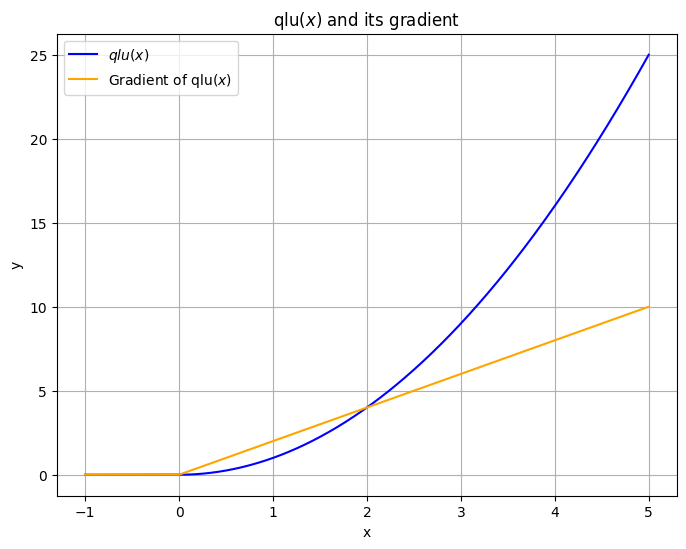

In [12]:
import matplotlib.pyplot as plt
# Generate x values
x = jnp.linspace(-1, 5, 1000)

y = qlu(x)
dy_dx = jax.vmap(jax.grad(lambda x: qlu(x)))(x)

# Plot the function and its gradient
plt.figure(figsize=(8, 6))
plt.plot(x, y, label=r"${qlu}(x)$", color='blue')
plt.plot(x, dy_dx, label=r"Gradient of $\mathrm{qlu}(x)$", color='orange')
plt.xlabel("x")
plt.ylabel("y")
plt.title(r"$\mathrm{qlu}(x)$ and its gradient")
plt.legend()
plt.grid(True)
plt.show()

In dieser Ansicht wird der Sprung in der Gradientenimplementierung bei $x=0$ nicht so ganz deutlich da in dem Array kein Eintrag mit 0.0 ist, deshalb nochmal die Visualisierung:

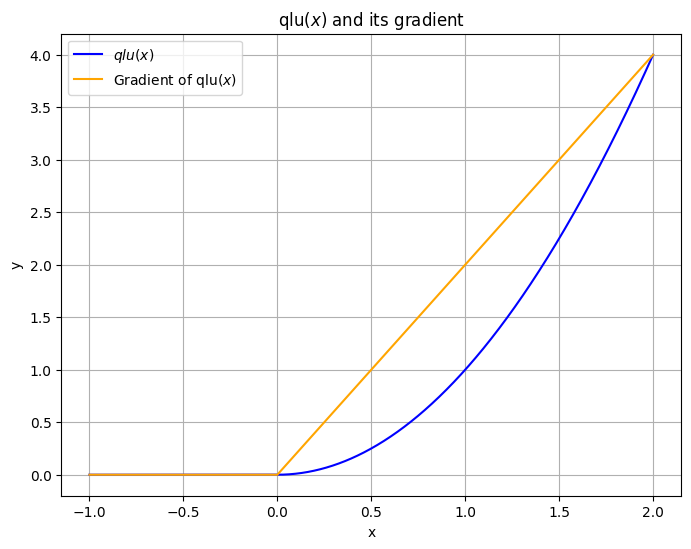

In [13]:
import matplotlib.pyplot as plt
# Generate x values
x = jnp.linspace(-1, 2, 1000)

y = qlu(x)
dy_dx = jax.vmap(jax.grad(lambda x: qlu(x)))(x)

# Plot the function and its gradient
plt.figure(figsize=(8, 6))
plt.plot(x, y, label=r"${qlu}(x)$", color='blue')
plt.plot(x, dy_dx, label=r"Gradient of $\mathrm{qlu}(x)$", color='orange')
plt.xlabel("x")
plt.ylabel("y")
plt.title(r"$\mathrm{qlu}(x)$ and its gradient")
plt.legend()
plt.grid(True)
plt.show()

### Kettenregel

Die Kettenregel wird besser erkenntlich, wenn wir die Ausgabe der Funktion $qlu(x)$ mit einer weiteren Funktion verketten, z.B. $sin(qlu(x))$. Die Kettenregel besagt, dass der Gradient der verketteten Funktion das Produkt der Gradienten der einzelnen Funktionen ist:
$$sin(x)' = \frac{d}{dx}(sin(qlu(x)))' = cos(qlu(x)) * qlu'(x)$$

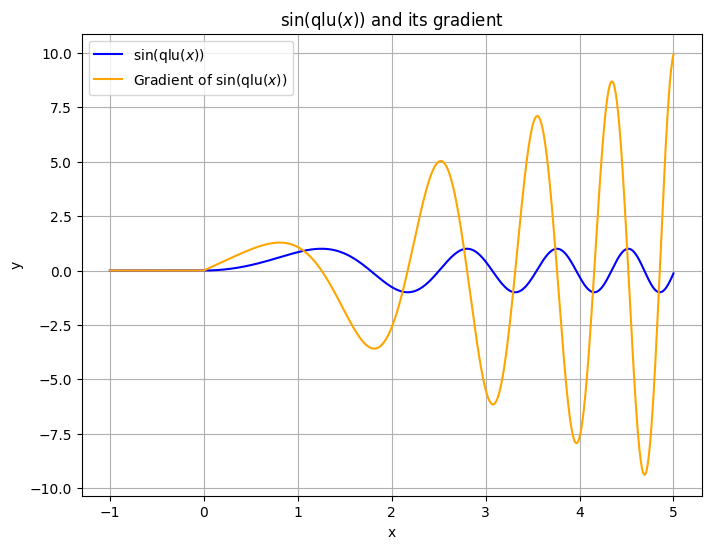

In [14]:
# Generate x values
x = jnp.linspace(-1, 5, 1000)

# Compute sin(qlu(x)) and its gradient
y = jnp.sin(qlu(x))
dy_dx = jax.vmap(jax.grad(lambda x: jnp.sin(qlu(x))))(x)

# Plot the function and its gradient
plt.figure(figsize=(8, 6))
plt.plot(x, y, label=r"$\sin(\mathrm{qlu}(x))$", color='blue')
plt.plot(x, dy_dx, label=r"Gradient of $\sin(\mathrm{qlu}(x))$", color='orange')
plt.xlabel("x")
plt.ylabel("y")
plt.title(r"$\sin(\mathrm{qlu}(x))$ and its gradient")
plt.legend()
plt.grid(True)
plt.show()